## Final part.. lets see if we can predict musicians who are 'successful' (i.e. high in popularity score and followers) 

### Loading data

In [36]:
import pandas as pd
import numpy as np

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

from utils import MusicDataLoader
from utils.test import featurize_mus,test
from utils import draw_tree

loader = MusicDataLoader()
mus_nodes = loader.get_features(n_release_bins=100)
mus_nodes.network_rank = mus_nodes.network_rank.fillna(0)

# add billboard data
billboard = pd.read_csv('data/charts.csv')
billboard.date = pd.to_datetime(billboard.date)
billboard['name'] = billboard.artist.str.split('&',n=1).str[0].str.split('Featuring').str[0].str.strip()
billboard = billboard.merge(mus_nodes,on='name')
after_date = billboard[billboard.date > '2021-7-01']
mus_nodes['is_billboard'] = mus_nodes.id.isin(after_date.id)
# mus_nodes.is_billboard.sum()

mus_nodes[  ~mus_nodes.first_release.isnull() 
            & ~mus_nodes.last_release.isnull()]
# special features added for this
name_features = lambda c: c.replace(
                            'Pop ', 'Collaborator Popularity '
                        ).replace(
                            'Fol ', 'Collaborator Followers '
                        ).replace(
                            'Rel ','Collaborator # Release '
                        )

### First, train XGBoost trees for each attribute

#### Predicting for Popularity score!

In [37]:
def train_tree(
    target='popularity',
    thres=80,
    exclude_features = [],
    extra_features = [],
    target_text='to have popularity > 80',
    xgb_setting = {}
):
    y,X_df = featurize_mus(
        mus_nodes,
        target,
        thres,
        exclude_features=exclude_features,
        extra_features=extra_features
        )

    cols = [name_features(' '.join([w.capitalize() for w in c.split('_')])) for c in X_df.columns]

    Xvals=X_df.values
    falsecount = (y==0).sum()
    print(f'Positive samples: {y.sum()/len(y) * 100}%')

    # resample for positive labels since we only have 100
    X_boost = resample(Xvals[y==1],random_state=0,replace=True,n_samples=falsecount)
    Xvals_resampled = np.vstack([Xvals[y==0],X_boost])
    y_resampled = np.array([0]*falsecount + [1]*falsecount)

    X_train, X_test, y_train, y_test = train_test_split(Xvals_resampled, y_resampled, test_size=0.2, random_state=0,shuffle=True)
    X_train,X_test = pd.DataFrame(X_train,columns=cols),pd.DataFrame(X_test,columns=cols)

    open('feat_for_xgb.txt','w')
    feats = pd.DataFrame()
    feats[0] = X_df.columns
    feats[1] = 'i'

    xg = XGBClassifier(**xgb_setting)

    test(xg,X_train,X_test,y_train,y_test)
    treedraw,ts = draw_tree.xgb(xg,target_text)
    pic = treedraw.render(f'pics/learned_xgboost_{target}.png',w=1200,units='mm',tree_style=ts)
    
    return {
        'target':target,
        'X':X_df,
        'y':y,
        'model':xg,
    }

#### Train trees and save the results and processed data for next step

In [38]:
data_settings = [
    {
        'target':'popularity',
        'thres':80,
        'exclude_features':['followers','network_rank'],
        'extra_features': ['rel_mean', 'rel_std', 'rel_max'],
        'target_text':'to have popularity > 80',
        'xgb_setting':{
            'random_state':0,
            'max_depth':3,
            'use_label_encoder':False,
            'n_estimators':1,
        }
    },{
        'target':'followers',
        'thres':1e7,
        'exclude_features':['popularity'],
        'extra_features':['rel_mean', 'rel_std', 'rel_max'],
        'target_text':'to have more than 1,000,000 followers',
        'xgb_setting':{
            'random_state':0,
            'max_depth':3,
            'reg_lambda':1000,
            'reg_alpha':20,
            'use_label_encoder':False,
            'n_estimators':1,
        }
    },{
        'target':'is_billboard',
        'thres':1,
        'exclude_features':['popularity','followers'],
        'extra_features':[  'pop_mean', 'pop_std', 'pop_max',
                            'fol_mean', 'fol_std', 'fol_max',
                            'rel_mean', 'rel_std', 'rel_max',],
        'target_text':'to place in billboard\'s hot 100',
        'xgb_setting':{
            'max_depth':3,
            'reg_lambda':1000,
            'reg_alpha':20,
            'random_state':0,
            'use_label_encoder':False,
            'verbosity':0,
            'n_estimators':1,
        }
    }
]

results = [train_tree(**s) for s in data_settings]

Positive samples: 2.7043781480046496%
<class 'xgboost.sklearn.XGBClassifier'>
training accuracy: 0.8039522703957669
[[9013 1039]
 [2592 7445]]
testing accuracy: 0.8023407022106632
[[2260  244]
 [ 668 1851]]
Positive samples: 0.9221232080588918%
<class 'xgboost.sklearn.XGBClassifier'>
training accuracy: 0.8854323628056191
[[8992 1263]
 [1094 9108]]
testing accuracy: 0.8827349121466769
[[2190  341]
 [ 273 2311]]
Positive samples: 0.8911274699728787%
<class 'xgboost.sklearn.XGBClassifier'>
training accuracy: 0.9048089127062473
[[8815 1439]
 [ 586 9624]]
testing accuracy: 0.9006548175865294
[[2178  358]
 [ 173 2407]]


### Now Let's try to analyze what we can change to make musicians successful

##### First make clusters and test perturbing each centroid

In [39]:
from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.neighbors import NearestCentroid,KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler

np.random.seed(0)

n_sample = 5000
max_steps = 100
n_clust = 300
perturb_settings = {
    'in_edges':1,
    'out_edges':1,
    'num_release':1,
    'rel_mean': 1,
    'rel_std': 1,
    'rel_max': 1,
    'pop_mean':1,
    'pop_std':1,
    'pop_max':1,
    'fol_mean':1e2,
    'fol_std':1e2,
    'fol_max':1e2,
    'last_release':pd.to_timedelta('30 days').value
}

perturb_results = []

def try_perturbing(
    target='',
    X=[],
    y=[],
    model=None
):
    print(target)

    X_not = X[y==0]
    X_yes = X[y==1]

    scaler = MinMaxScaler()
    scaled_original = scaler.fit_transform(X_not)

    kmeans = KMeans(n_clusters = n_clust,random_state = 0)

    cluster_labels = kmeans.fit_predict(scaled_original)
    print('distribution:',np.unique(cluster_labels,return_counts=True)[1])
    centroids = NearestCentroid().fit(scaled_original,cluster_labels).centroids_
    # undo the scaling for clustering
    centroids = scaler.inverse_transform(centroids)
    
    # now link with columns from how they are ordered
    weights = np.array([
        perturb_settings[c] 
            if c in perturb_settings else 
        0
        for c in X.columns
    ])

    # gotta have rules so our values are not unrealistic
    perturb_limits_upper = {
        'pop_max':100,
        'pop_mean':100,
        'last_release':pd.to_datetime('2021-09-01').value,
    }

    successful = []

    for c in centroids:
        perturbation = np.vstack([
                            np.zeros((1,c.shape[0])),
                            (np.random.random((n_sample,c.shape[0]))*max_steps).astype(int) + weights
                        ])
        # first row of perturbed contains the original!!
        perturbed = perturbation + c
        
        # probably not efficient, but casting to dataframe for easier filtering
        perturbed = pd.DataFrame(perturbed,columns=X.columns)
        for k,v in perturb_limits_upper.items():
            if k in X.columns:
                perturbed = perturbed[perturbed[k] <= v]   
                    
        predicted = model.predict(perturbed.values)
        # it there is any positive sample excluding the original point, we save it
        if predicted.any() and not predicted[0]:
            successful.append({
                'original': c,
                'pert':perturbed,
                'pred': predicted,
            })
        
    print(f'Successfully perturbed {len(successful)} out of {n_clust}')
        
    return {
        'target':target,    
        'successful':successful
    }
    
perturb_results = [try_perturbing(**res) for res in results]


popularity
distribution: [ 14  70 189  24 107  10  17   6  13 227   3   4  25   6   6  19   8  62
   8   2  83  71  25   2   4 813  12   7   4   2   8  22  15 160 190  14
  21  20  29  24  14 123  15  14   2  36  28  23  11  31  39   6  31  20
  34  54  20   9  29  67   7  35  15   3  15   5   5  17  15  82 504   7
  10  20  39  29   6  32 191  22   5  51   9  13  57   7 115  51   2   2
   1 224   6  18  26   3  11  90  12 305  20   4   2  22   8   3  33  13
 155  60  17   9  91  38   8  15  11  17   1 201  26  15  12  36   8  47
  13  55  23   5 263   6  18   8  19  15   7  11  15  59   7   7  31  13
  45 189  44   7  32  51   2   7  34   6 133 167  10  28  13  17   6  34
  39  23  11  33   3  29   9   7   2  13  20  29  53   2  18  23  13  32
  39   2  12  37  37  15   7  21  28   3  17   3  11  44  22 166   3  15
   7  20  95  84  15  99  20  61 548   1   9   6  16  51  40   2  13   7
   3 333  79  58  34   5  49  34 213  65  10   7   5  59   4  30  24   3
   1   1   8  11  13  29  

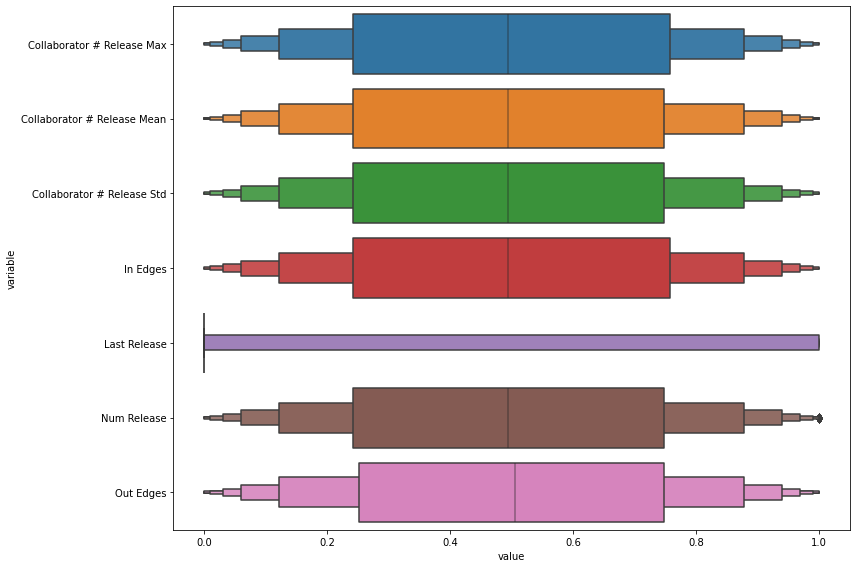

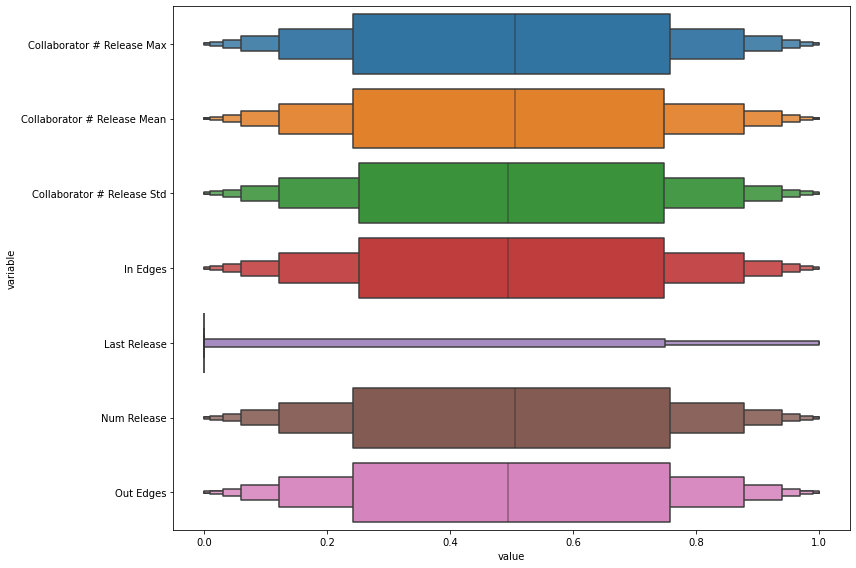

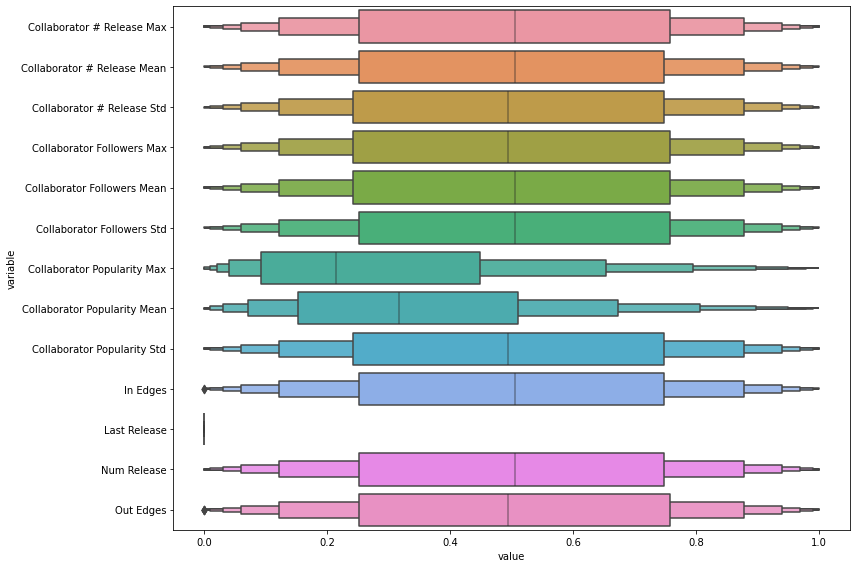

In [55]:
def plot_perturb_dist(target='',successful=[]):
    cols = set(perturb_settings.keys()) & set(successful[0]['pert'].columns) 
    differences = pd.DataFrame(
        MinMaxScaler().fit_transform(
            np.vstack([
                s['pert'][cols][1:].values-s['pert'][cols][:1].values
                for s in successful
            ])),
        columns= [
            name_features(' '.join([w.capitalize() for w in c.split('_')]))
            for c in cols
        ]
        ).sort_index(axis=1)

    import seaborn as sns
    import matplotlib.pyplot as plt

    fig,ax = plt.subplots(figsize=(12,8))

    sns.boxenplot(
        data=differences.melt(value_vars=differences.columns),
        x='value',
        y='variable',
        ax=ax
    )

    plt.tight_layout()
    
    fig.savefig(f'pics/perturbation/{target}_dist.png',dpi=300)
    
for res in perturb_results:
    plot_perturb_dist(**res)

##### Now that we have the results, let's plot the perturbances

In [41]:
import plotly.express as px
from tqdm import tqdm

overwrite_mask = ['Career Length','Last Release','First Release']

# for target,res in perturb_results.items():
def make_plots(
    target='',
    successful=[],
):
    for i,t in enumerate(tqdm(successful,desc=target)):
        pert,pred = t['pert'],t['pred']
        # differences
        scaled_suc_dif = pd.DataFrame(
                            MinMaxScaler().fit_transform(pert[pred==1]),
                            columns=[
                                name_features(' '.join([w.capitalize() for w in c.split('_')]))
                                    for c in 
                                pert.columns
                            ]
                        ).sort_index(axis=1)

        

        original_df = scaled_suc_dif[:1].copy()
        perturbed_df = scaled_suc_dif[1:].copy()

        # lets find the closest and furthest perturbations
        perturbed_df['dist'] = ((original_df.values - perturbed_df.values)**2).sum(1)
        sorted_by_dist = perturbed_df.sort_values(by=['dist'])
        closest,furthest = sorted_by_dist.index[0],sorted_by_dist.index[-1]

        radar_plot = lambda df: (
            px.line_polar(
                df.reset_index().melt(id_vars='index',value_vars=df.columns),
                r='value',
                theta='variable',
                color='index',
                line_close=True,
                range_r = (-5,2),
            ).update_layout(
                polar = {
                    'radialaxis':{
                        'showticklabels':False,
                        'showline':False
                    }
                },
                # margin = {'r':100},
                autosize=False,
                width = 900,
                height= 500,
                # polar_angularaxis_showticklabels=False
            ).update_traces(
                fill='toself'
            )
        )

        df = scaled_suc_dif.iloc[[0,closest]].copy()
        df[overwrite_mask] = scaled_suc_dif[overwrite_mask].values[0]
        df.index=['Original','Closest Perturbation']
        radar_plot(df).write_image(
            f'pics/perturbation/{target}/{target}_{i}_closest.png',
            scale=8,
            # margin = {'r':100}
        )
        unscaled_df = pert[1:].iloc[[0,closest]]
        unscaled_df.to_csv(f'pics/perturbation/{target}/{target}_{i}_closest_data.csv',index=False)

        df = scaled_suc_dif.iloc[[0,furthest]].copy()
        df[overwrite_mask] = scaled_suc_dif[overwrite_mask].values[0]
        df.index=['Original','Furthest Perturbation']
        radar_plot(df).write_image(
            f'pics/perturbation/{target}/{target}_{i}_furthest.png',
            scale=8,
            # margin = {'r':100}
        )
        unscaled_df = pert[1:].iloc[[0,furthest]]
        unscaled_df.to_csv(f'pics/perturbation/{target}/{target}_{i}_furthest_data.csv',index=False)


for res in perturb_results: 
    make_plots(**res)

is_billboard: 100%|██████████| 35/35 [00:47<00:00,  1.36s/it]


##### Findings:

Follower count: collaborator releases and one's number of releases seems to be the most impactful
Popularity score: Artist's own release count as well as number of collaborations (incomeing or outgoing edges) 
Billboard: 